In [2]:
import numpy as np
import pandas as pd
import matplotlib
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import copy
import os
import re
import shutil

from sklearn.tree import export_graphviz
import graphviz

%matplotlib inline
matplotlib.use('module://ipykernel.pylab.backend_inline')

# RANDOM_STATE = 25 
# 43: 0.04, -0.015
RANDOM_STATE = 42

/tmp/ipykernel_21834/1661499779.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
n_samples =None
memory_experiment = "pm"
remove_na = True

second_visit = 2
gender = None
iqr_coefficient = None# if None then no standrat removal of outliers
outcome = f"z_global_change.0.{second_visit}"
#outcome = f"z_change_snap_game_true_pos_rt_avrg.0.{second_visit}"
# outcome =f"z_change_log_pairs_matching_sum_incorrect.0.{second_visit}"


# outcome = f"z_change_num_memory_max_digits_remembered_correctly.0.{second_visit}"

input_file = f"/projects/prime/ukbb/results_2024/{memory_experiment}_sg_0_{second_visit}_18_06_all_learning/data_with_na.csv"
output_dir = f"/projects/prime/ukbb/results_2024/{memory_experiment}_sg_0_{second_visit}_18_06_all_learning/regressor_all_predictors_{memory_experiment}_{outcome}"

if gender is None:
  output_dir = f"{output_dir}/"
else:
  output_dir = f"{output_dir}_gender_{gender}/"
if not os.path.exists(output_dir):
  os.makedirs(output_dir)



In [4]:
# function for removing outliers via iqr approach
def remove_outliers_iqr(df_, iqr_cf,  outliers):
    print(f"# data points before removing outliers: {len(df_)}")
    if iqr_cf is not None:
        
        lower_bound = {}
        upper_bound = {}
        
        for feat  in outliers:
            print(f"{feat}")
            
            Q1 = df_[feat].quantile(0.25)
            Q3 = df_[feat].quantile(0.75)
            
            IQR = Q3-Q1
            lower_bound[feat] = Q1 - iqr_cf * IQR
            upper_bound[feat] = Q3 + iqr_cf * IQR
            
            
            
        for feat in lower_bound:
            df_= df_[(df_[feat] >= lower_bound[feat]) & (df_[feat] <= upper_bound[feat])]
            
        print(f"# data points after removing outliers: {len(df_)}")
    return(df_)

In [5]:
# global change on pm, demo case  200, 20, 10 (0.04, -0.02), 80% train, include alc, global
predictors = ["gender.0", f"time_difference.0.{second_visit}", "age_years.0", "education_level.0", 
              "Diabetes_2.0",  "Dyslipidemia.0", "Depression.0", "Hypertension.0",
               "Syst_bp.0", "Diast_bp.0", "hdl_conv.0", "ldl_conv.0",  "HbA1c_conv.0",
               "C_reactive_protein.0",  "Albumin.0", "Leukocyte_count.0",
               "waist_cm.0",  "bmi_kg_m2.0", "MET_score.0", "marital_status.0", "pp_smoke_catgeory.0",
               "oily_fish_gpday_bradbury.0", "white_fish_gpday_bradbury.0", 
   "red_meat_bradbury_gpd.0", "poultry_gpday_bradbury.0",
   "processed_meat_gpday_bradbury.0", "veg_gpday_bradbury.0",
   "fruit_gpday_bradbury.0", "bread_gpday_bradbury.0", "cheese_gpday_bradbury.0",
    "tea_gpday_bradbury.0", 
    "red_wine_gpd.0", "white_wine_gpd.0", "fortified_gpd.0", "beer_cider_gpd.0", "spirits_gpd.0",
    "aspirin.0",  "anxiety_tr.0", "pain_tr.0", "TAZD_Thiazide.0",  
   "loop_diuretics.0",  "potassium_diuretics.0", "beta_blockers.0", "calcium_antagonists.0", 
   "ARA_II_Antagonists_of_angiotensin_II_receptors.0", "IECA_Angiotensin_converting_enzyme_inhibitors.0",
   "Other_Hypotensive.0","hypochol_statins.0", "hypochol_others.0", "insulin.0", "sulfonylurea.0", "thiazolidinediones.0", 
   "non_sulfonylurea_insulin_secretagogues.0", "metformin_category.0", "vitamins_minerals.0"]

In [6]:
# 900, 5  log
'''predictors = ["gender.0", f"log_time_difference.0.{second_visit}", 
              "Diabetes_2.0",  "Dyslipidemia.0", "Depression.0", "Hypertension.0", 
  "age_years.0", "education_level.0", "marital_status.0", "pp_smoke_catgeory.0", "log_MET_score.0", "log_waist_cm.0",  "log_bmi_kg_m2.0", 
  "Syst_bp.0", "Diast_bp.0", "log_ldl_conv.0", "log_hdl_conv.0", "log_Triglycerides_conv.0", "log_HbA1c_conv.0",  "log_Pl_glucose_conv.0",   "log_Albumin.0", 
  "log_Leukocyte_count.0", "log_C_reactive_protein.0",
   "log_oily_fish_gpday_bradbury.0", "log_white_fish_gpday_bradbury.0", 
   "log_red_meat_bradbury_gpd.0", "log_poultry_gpday_bradbury.0",
   "log_processed_meat_gpday_bradbury.0", "log_veg_gpday_bradbury.0",
   "log_fruit_gpday_bradbury.0",
    "log_cereals_gpday_bradbury.0", "log_bread_gpday_bradbury.0", "log_cheese_gpday_bradbury.0",
    "log_milk_gpday_bradbury.0", "log_tea_gpday_bradbury.0",
    "log_red_wine_gpd.0", "log_white_wine_gpd.0", "log_fortified_gpd.0", "log_beer_cider_gpd.0", "log_spirits_gpd.0",
   "aspirin.0",  "anxiety_tr.0", "pain_tr.0", "TAZD_Thiazide.0",  
   "loop_diuretics.0",  "potassium_diuretics.0", "beta_blockers.0", "calcium_antagonists.0", 
   "ARA_II_Antagonists_of_angiotensin_II_receptors.0", "IECA_Angiotensin_converting_enzyme_inhibitors.0",
   "Other_Hypotensive.0","hypochol_statins.0", "hypochol_others.0", "insulin.0", "sulfonylurea.0", "thiazolidinediones.0", "non_sulfonylurea_insulin_secretagogues.0", "metformin_category.0", "vitamins_minerals.0"]'''

'predictors = ["gender.0", f"log_time_difference.0.{second_visit}", \n              "Diabetes_2.0",  "Dyslipidemia.0", "Depression.0", "Hypertension.0", \n  "age_years.0", "education_level.0", "marital_status.0", "pp_smoke_catgeory.0", "log_MET_score.0", "log_waist_cm.0",  "log_bmi_kg_m2.0", \n  "Syst_bp.0", "Diast_bp.0", "log_ldl_conv.0", "log_hdl_conv.0", "log_Triglycerides_conv.0", "log_HbA1c_conv.0",  "log_Pl_glucose_conv.0",   "log_Albumin.0", \n  "log_Leukocyte_count.0", "log_C_reactive_protein.0",\n   "log_oily_fish_gpday_bradbury.0", "log_white_fish_gpday_bradbury.0", \n   "log_red_meat_bradbury_gpd.0", "log_poultry_gpday_bradbury.0",\n   "log_processed_meat_gpday_bradbury.0", "log_veg_gpday_bradbury.0",\n   "log_fruit_gpday_bradbury.0",\n    "log_cereals_gpday_bradbury.0", "log_bread_gpday_bradbury.0", "log_cheese_gpday_bradbury.0",\n    "log_milk_gpday_bradbury.0", "log_tea_gpday_bradbury.0",\n    "log_red_wine_gpd.0", "log_white_wine_gpd.0", "log_fortified_gpd.0", "log_beer_

In [7]:
df = pd.read_table(input_file, nrows=n_samples,sep =",")
df = df[predictors+[outcome]]
print(f"data set {len(df)} rows")
if remove_na:
    df = df.dropna(axis="rows")
    print(f"cleaned check up db has {len(df)} rows")
 
if gender is not None:
   df = df[df["gender.0"].eq(gender) ]
   predictors.remove("gender.0")
   df = df.drop(columns=["gender.0"], axis=1)
       
df = remove_outliers_iqr(df, iqr_coefficient, df.columns) 

data set 502204 rows
cleaned check up db has 18862 rows
# data points before removing outliers: 18862


In [8]:
features = [x for x in df.columns if x not in [outcome, outcome]]
# features = [x for x in df.columns if x not in outcome]

In [9]:
print(features)

['gender.0', 'time_difference.0.2', 'age_years.0', 'education_level.0', 'Diabetes_2.0', 'Dyslipidemia.0', 'Depression.0', 'Hypertension.0', 'Syst_bp.0', 'Diast_bp.0', 'hdl_conv.0', 'ldl_conv.0', 'HbA1c_conv.0', 'C_reactive_protein.0', 'Albumin.0', 'Leukocyte_count.0', 'waist_cm.0', 'bmi_kg_m2.0', 'MET_score.0', 'marital_status.0', 'pp_smoke_catgeory.0', 'oily_fish_gpday_bradbury.0', 'white_fish_gpday_bradbury.0', 'red_meat_bradbury_gpd.0', 'poultry_gpday_bradbury.0', 'processed_meat_gpday_bradbury.0', 'veg_gpday_bradbury.0', 'fruit_gpday_bradbury.0', 'bread_gpday_bradbury.0', 'cheese_gpday_bradbury.0', 'tea_gpday_bradbury.0', 'red_wine_gpd.0', 'white_wine_gpd.0', 'fortified_gpd.0', 'beer_cider_gpd.0', 'spirits_gpd.0', 'aspirin.0', 'anxiety_tr.0', 'pain_tr.0', 'TAZD_Thiazide.0', 'loop_diuretics.0', 'potassium_diuretics.0', 'beta_blockers.0', 'calcium_antagonists.0', 'ARA_II_Antagonists_of_angiotensin_II_receptors.0', 'IECA_Angiotensin_converting_enzyme_inhibitors.0', 'Other_Hypotensive.

In [10]:
X_train, X_val, y_train, y_val = train_test_split(df[features], df[outcome], train_size = 0.8, random_state = RANDOM_STATE)

In [11]:
print(f'train samples: {len(X_train)}')
print(f'validation samples: {len(X_val)}')
min_ = df[outcome].min()
max_ = df[outcome].max()
median_ = df[outcome].median()
mean_ = df[outcome].mean()
print(f"tr min {outcome}: {min_}")
print(f"tr max {outcome}: {max_}")
print(f"tr median {outcome}: {median_}")
print(f"tr mean {outcome}: {mean_}")

train samples: 13203
validation samples: 5659
tr min z_global_change.0.2: -7.284689450016188
tr max z_global_change.0.2: 5.122991928244291
tr median z_global_change.0.2: -0.34957020857014603
tr mean z_global_change.0.2: -0.35781906991943635


In [12]:
def r1(y_pred, y_true, median_):
    abs_error_pred = (np.abs(y_true - y_pred)).sum()
    abs_error = (np.abs(y_true - median_)).sum()
    r1 = 1 -abs_error_pred/abs_error
    return r1

y_tr = pd.Series([1,2,3])
m_ = y_tr.median()
print(f"test median {m_}")
y_pr = pd.Series([m_, m_, m_]) # 
test = r1(y_pr, y_tr, m_)
print(f"test r1 function: {test}")

test median 2.0
test r1 function: 0.0


MAE train:
	: 0.7658
MAE validation:
	: 0.8334
RMSE train:
	: 1.0012
RMSE validation:
	: 1.0661
R1 train:
	: 0.0458
R1 validation:
	: -0.0308
R2 train:
	: -11.6303
R2 validation:
	: -13.2808
                        feature  importance
0           time_difference.0.2    0.164050
1                   age_years.0    0.087859
2                     Syst_bp.0    0.019315
3                    Diast_bp.0    0.017959
4                    hdl_conv.0    0.083942
5                    ldl_conv.0    0.038265
6                  HbA1c_conv.0    0.051084
7          C_reactive_protein.0    0.019155
8                     Albumin.0    0.064257
9             Leukocyte_count.0    0.091856
10                   waist_cm.0    0.030473
11                  bmi_kg_m2.0    0.029609
12                  MET_score.0    0.055776
13          pp_smoke_catgeory.0    0.014604
14   oily_fish_gpday_bradbury.0    0.029149
15  white_fish_gpday_bradbury.0    0.016258
16      red_meat_bradbury_gpd.0    0.007810
17     poultry_gp

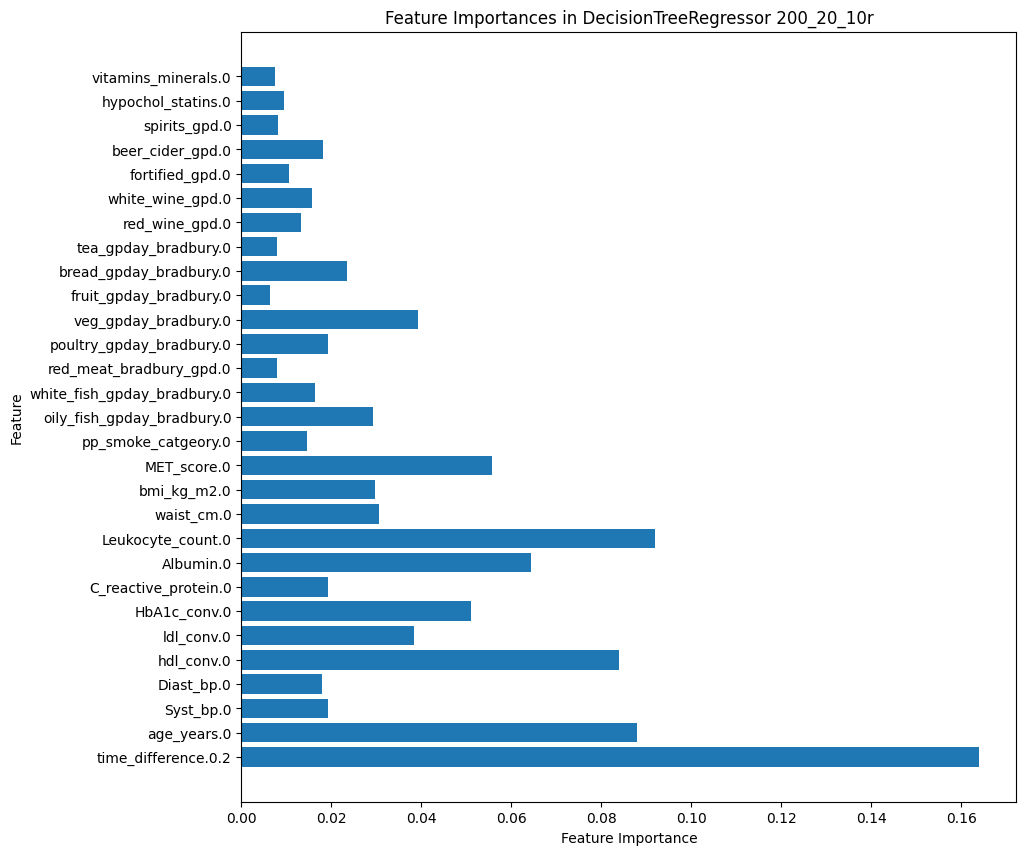

In [30]:
# global change on pm, demo case  200, 20, 10 (0.04, -0.02), 80 train, random = 42; 400 is ook ok
# numeric memory better metrics 20, 10, 12 (0.07, 0.02) 80 train
# beter smal tree with  squared error

m_smaples_split = 200
m_samples_leaf = 20
m_depth = 10
specific_name = f"{m_smaples_split}_{m_samples_leaf}_{m_depth}r"

regressor = DecisionTreeRegressor(min_samples_leaf = m_samples_leaf,
                                  min_samples_split =  m_smaples_split,
                                  max_depth = m_depth, 
                                  criterion ="rse",
                                  random_state = RANDOM_STATE)

regression_tree_model = regressor.fit(X_train,y_train)

print(f"MAE train:\n\t: {mean_absolute_error(regression_tree_model.predict(X_train),y_train):.4f}")
print(f"MAE validation:\n\t: {mean_absolute_error(regression_tree_model.predict(X_val),y_val):.4f}")
print(f"RMSE train:\n\t: {np.sqrt(mean_squared_error(regression_tree_model.predict(X_train),y_train)):.4f}")
print(f"RMSE validation:\n\t: {np.sqrt(mean_squared_error(regression_tree_model.predict(X_val),y_val)):.4f}")
print(f"R1 train:\n\t: {r1(regression_tree_model.predict(X_train),y_train,median_):.4f}")
print(f"R1 validation:\n\t: {r1(regression_tree_model.predict(X_val),y_val, median_):.4f}")
print(f"R2 train:\n\t: {r2_score(regression_tree_model.predict(X_train),y_train):.4f}")
print(f"R2 validation:\n\t: {r2_score(regression_tree_model.predict(X_val),y_val):.4f}")


# Retrieve the feature importances
importances = regression_tree_model.feature_importances_

# Print the feature importances
important_features = []
important_importances = []
df_importances = pd.DataFrame()

for feature_name, importance in zip(features, importances):
    if importance > 0:
        important_features.append(feature_name)
        important_importances.append(importance)
        new_row = {'feature': feature_name, 'importance': importance}
        new_row_df = pd.DataFrame([new_row])
        df_importances = pd.concat([df_importances, new_row_df], ignore_index=True)
        
print(df_importances)       
df_importances.to_csv(f"{output_dir}/feature_importance_{m_smaples_split}_{m_samples_leaf}_{specific_name}.csv", sep =",")
# Visualize the feature importances
plt.figure(figsize=(10, 10))
plt.barh(important_features, important_importances, align='center')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title(f"Feature Importances in DecisionTreeRegressor {specific_name}")
file_path = os.path.join(output_dir, 'feature_importances.png')
plt.savefig(file_path)
plt.show()

In [29]:
# adjusting colors
values = regressor.tree_.value.flatten()
# Normalize the values for coloring
norm = plt.Normalize(values.min(), values.max())
# Create a custom color map (green to red)
cmap = mcolors.LinearSegmentedColormap.from_list("GreenYellowRed", ["red", "yellow", "green"])

# Generate colors for each node based on the normalized values and the custom color map
colors = cmap(norm(values))

dot_data_1 = export_graphviz(regressor,  out_file=None, filled=True, rounded=True, special_characters=True,
                           feature_names=features,
                           proportion=True)


# Split the DOT data into lines
dot_lines = dot_data_1.splitlines()
hex_color_pattern = r'fillcolor="#[0-9a-fA-F]{6}"'

# Modify the DOT file lines to include custom colors
new_dot_lines = []
for line in dot_lines:
    if 'fillcolor' in line:
        parts = line.split()
        if parts[0].isdigit():
            node_id = int(parts[0])
            # Get corresponding color
            color = mcolors.to_hex(colors[node_id])
            # Modify the line to include the color
            line = re.sub(hex_color_pattern, f'fillcolor="{color}"', line)
    new_dot_lines.append(line)

# Combine the modified lines back into a single string
new_dot_data = "\n".join(new_dot_lines)

# Render the DOT file with Graphviz
graph = graphviz.Source(new_dot_data)
graph.render(f"regression_tree_custom_color", format='png')
graph.render(f"{output_dir}/regression_tree_custom_color", format='png')
graph.view()

'/projects/prime/ukbb/results_2024/pm_sg_0_2_18_06_all_learning/regressor_all_predictors_pm_z_global_change.0.2/regression_tree_custom_color.pdf'

Error: no "view" mailcap rules found for type "application/pdf"
Try running the update-desktop-database command. If you
don't have this command you should install the
desktop-file-utils package. This package is available from
http://freedesktop.org/wiki/Software/desktop-file-utils/
Can't call method "get_value" on an undefined value at /usr/bin/mimeopen line 159.


In [23]:
def eval_node(X, y, logical_path, out_, interval_left, interval_right):
    df_left = pd.concat([X, y], axis=1)
    df_right = pd.concat([X, y], axis=1)
    print(len(logical_path))
    for i in range(len(logical_path)-1):
        predicate = logical_path[i]
        print(predicate)
        if predicate[1] == "le":
            df_left= df_left[df_left[predicate[0]].le(predicate[2])]
            df_right= df_right[df_right[predicate[0]].le(predicate[2])]
        else:
            df_left = df_left[df_left[predicate[0]].gt(predicate[2])]
            df_right = df_right[df_right[predicate[0]].gt(predicate[2])]
        
    predicate=logical_path[-1]
    print(predicate)
    df_left= df_left[df_left[predicate[0]].le(predicate[2])]
    df_right = df_right[df_right[predicate[0]].gt(predicate[2])]
            
    median_left = df_left[out_].median()
    q1_left = df_left[out_].quantile(0.25)
    q3_left = df_left[out_].quantile(0.75)
    mean_left = df_left[out_].mean()
    std_left = df_left[out_].std()
        
    median_right = df_right[out_].median()
    q1_right = df_right[out_].quantile(0.25)
    q3_right = df_right[out_].quantile(0.75)
    mean_right= df_right[out_].mean()
    std_right = df_right[out_].std()
        
    if interval_left is not None:
        n_within_interval_left = (df_left[out_].ge(interval_left[0]) & df_left[out_].le(interval_left[1])).sum()
        percentage_within_interval_left = (n_within_interval_left * 100)/len(df_left)
    else:
        percentage_within_interval_left = None
        
    if interval_right is not None:
        n_within_interval_right = (df_right[out_].ge(interval_left[0]) & df_right[out_].le(interval_left[1])).sum()
        percentage_within_interval_right = (n_within_interval_right * 100)/len(df_right)
    else:
        percentage_within_interval_right = None
        
    ret_val = {
            "median": [median_left,median_right],
            "q1": [q1_left, q1_right],
            "q3": [q3_left, q3_right],
            "mean": [mean_left, mean_right],
            "std": [std_left, std_right],
            "percentage_within_interval": [percentage_within_interval_left, percentage_within_interval_right]
        }
    return ret_val

In [16]:
hdl_path = [['time_difference.0.2', "le", 3357.5], ["waist_cm.0", "le", 104.5], ["hdl_conv.0", "le", 43.17]]
tr_node_stat = eval_node(X_train, y_train, hdl_path, outcome, None, None)
print(tr_node_stat)


3
['time_difference.0.2', 'le', 3357.5]
['waist_cm.0', 'le', 104.5]
['hdl_conv.0', 'le', 43.17]
{'median': [-0.3421624132336548, -0.185104256339518], 'q1': [-0.9905145114982958, -0.8657611167655939], 'q3': [0.31964199151223927, 0.44687576071711776], 'mean': [-0.36009767710477186, -0.2066006851064761], 'std': [1.00445822028342, 1.0226502994573543], 'percentage_within_interval': [None, None]}


In [17]:

interval_left_hdl = [tr_node_stat["mean"][0] - tr_node_stat["std"][0], tr_node_stat["mean"][0] + tr_node_stat["std"][0]]
interval_right_hdl = [tr_node_stat["mean"][1] - tr_node_stat["std"][1], tr_node_stat["mean"][1] + tr_node_stat["std"][1]]
val_node_stat  = eval_node(X_val, y_val, hdl_path, outcome, interval_left_hdl, interval_right_hdl)
print(val_node_stat)

3
['time_difference.0.2', 'le', 3357.5]
['waist_cm.0', 'le', 104.5]
['hdl_conv.0', 'le', 43.17]
{'median': [-0.1814201218210005, -0.2320992364236752], 'q1': [-0.8469922032505223, -0.8759005756437419], 'q3': [0.4493011611873397, 0.42305454200204956], 'mean': [-0.17365321840051393, -0.21390847424656834], 'std': [1.0083522937564087, 1.0185114838387688], 'percentage_within_interval': [66.66666666666667, 69.38356164383562]}


In [18]:
waist_path = [['time_difference.0.2', "le", 3357.5], ["waist_cm.0", "le", 104.5]]
tr_node_stat = eval_node(X_train, y_train, waist_path, outcome, None, None)
print(tr_node_stat)
interval_left_waist = [tr_node_stat["mean"][0] - tr_node_stat["std"][0], tr_node_stat["mean"][0] + tr_node_stat["std"][0]]
interval_right_waist = [tr_node_stat["mean"][1] - tr_node_stat["std"][1], tr_node_stat["mean"][1] + tr_node_stat["std"][1]]
val_node_stat  = eval_node(X_val, y_val, waist_path, outcome, interval_left_waist, interval_right_waist)
print(val_node_stat)

2
['time_difference.0.2', 'le', 3357.5]
['waist_cm.0', 'le', 104.5]
{'median': [-0.2093153054134455, -0.36923376702886057], 'q1': [-0.8787224372144213, -0.9798134464385554], 'q3': [0.4299848460883168, 0.3785610703072729], 'mean': [-0.22895574639371208, -0.30133915194018807], 'std': [1.0213318660539796, 1.008742853262672], 'percentage_within_interval': [None, None]}
2
['time_difference.0.2', 'le', 3357.5]
['waist_cm.0', 'le', 104.5]
{'median': [-0.2282038459345065, -0.2196588633976835], 'q1': [-0.8717859656788187, -0.812336612267551], 'q3': [0.4263876951934866, 0.386514850650359], 'mean': [-0.20853314334724357, -0.15820470298392258], 'std': [1.0169553814243646, 0.9529549266555636], 'percentage_within_interval': [70.97922848664689, 74.44444444444444]}


In [19]:
hb1ac_path = [['time_difference.0.2', "gt", 3357.5], ["age_years.0", "gt", 59.5], ["HbA1c_conv.0", "le", 5.549]]
tr_node_stat = eval_node(X_train, y_train, hb1ac_path, outcome, None, None)
print(tr_node_stat)
interval_left_waist = [tr_node_stat["mean"][0] - tr_node_stat["std"][0], tr_node_stat["mean"][0] + tr_node_stat["std"][0]]
interval_right_waist = [tr_node_stat["mean"][1] - tr_node_stat["std"][1], tr_node_stat["mean"][1] + tr_node_stat["std"][1]]
val_node_stat  = eval_node(X_val, y_val, hb1ac_path, outcome, interval_left_waist, interval_right_waist)
print(val_node_stat)

3
['time_difference.0.2', 'gt', 3357.5]
['age_years.0', 'gt', 59.5]
['HbA1c_conv.0', 'le', 5.549]
{'median': [-0.4898007057970538, -0.6356717117599853], 'q1': [-1.1743132620972094, -1.2378284242762208], 'q3': [0.1680455788323646, 0.059559987331064226], 'mean': [-0.5254454831995083, -0.6264249648110353], 'std': [1.0294603658806556, 1.0583740600382543], 'percentage_within_interval': [None, None]}
3
['time_difference.0.2', 'gt', 3357.5]
['age_years.0', 'gt', 59.5]
['HbA1c_conv.0', 'le', 5.549]
{'median': [-0.3908590197528229, -0.5310621936451709], 'q1': [-1.1241754006558016, -1.1850961071771753], 'q3': [0.215621355481584, 0.2243490324133242], 'mean': [-0.4535413284424328, -0.48880759679421304], 'std': [1.123514884460817, 1.1805413177513033], 'percentage_within_interval': [68.45930232558139, 66.44067796610169]}


In [25]:
# mse, depth = 3,
MET_path = [['time_difference.0.2', "le", 3488.5], ["Leukocyte_count.0", "gt", 13.625], ["MET_score.0", "le", 6465.0]]
tr_node_stat = eval_node(X_train, y_train, MET_path, outcome, None, None)
print(tr_node_stat)
interval_left_waist = [tr_node_stat["mean"][0] - tr_node_stat["std"][0], tr_node_stat["mean"][0] + tr_node_stat["std"][0]]
interval_right_waist = [tr_node_stat["mean"][1] - tr_node_stat["std"][1], tr_node_stat["mean"][1] + tr_node_stat["std"][1]]
val_node_stat  = eval_node(X_val, y_val, MET_path, outcome, interval_left_waist, interval_right_waist)
print(val_node_stat)

3
['time_difference.0.2', 'le', 3488.5]


['Leukocyte_count.0', 'gt', 13.625]
['MET_score.0', 'le', 6465.0]
{'median': [-2.0538418010110115, 0.4375191513479518], 'q1': [-2.4278020073163638, 0.4375191513479518], 'q3': [-1.574762619225997, 0.4375191513479518], 'mean': [-2.0261140290657793, 0.4375191513479518], 'std': [0.5676876003704463, nan], 'percentage_within_interval': [None, None]}
3
['time_difference.0.2', 'le', 3488.5]
['Leukocyte_count.0', 'gt', 13.625]
['MET_score.0', 'le', 6465.0]
{'median': [-0.16368561424523245, -0.0392645392235341], 'q1': [-0.2455284213678487, -0.0392645392235341], 'q3': [-0.08184280712261623, -0.0392645392235341], 'mean': [-0.16368561424523245, -0.0392645392235341], 'std': [0.23148641563097844, nan], 'percentage_within_interval': [0.0, 0.0]}


In [ ]:
# ARA_II_Antagonists_of_angiotensin_II_receptors.0
df_case_train = pd.concat([X_train, y_train], axis=1)
df_case_train= df_case_train[df_case_train["age_years.0"].gt(59.5) & 
                             df_case_train["time_difference.0.2"].gt(3357.5) &
                             df_case_train["HbA1c_conv.0"].gt(5.549) &
                             df_case_train["white_fish_gpday_bradbury.0"].le(19.5) &
                             df_case_train["red_meat_bradbury_gpd.0"].gt(44.0) &
                             df_case_train["ARA_II_Antagonists_of_angiotensin_II_receptors.0"].gt(0.5)]
print(f" train ARA ")
print(f"size train case: {len(df_case_train)}")

mean_ = df_case_train[outcome].mean()
print(f"mean train case: {mean_}")
error_ = df_case_train[outcome].std()
print(f"std train case: {error_}")
min_ = df_case_train[outcome].min()
print(f"min train case: {min_}")
max_ = df_case_train[outcome].max()
print(f"max train case: {max_}")
median_tr = df_case_train[outcome].median()
print(f"median train case: {median_tr}")
q1_tr = df_case_train[outcome].quantile(0.25)
q3_tr = df_case_train[outcome].quantile(0.75)
print(f"q1 train case: {q1_tr}")
print(f"q3 train case: {q3_tr}")

n_train_inside = (df_case_train[outcome].ge(mean_-error_) & df_case_train[outcome].le(mean_+error_)).sum()
percentage_tr_inside = (n_train_inside * 100)/len(df_case_train) 
print(f"percentage train inside the std interval: {percentage_tr_inside:.2f}")


# case specific 
n_hypertension = df_case_train["Hypertension.0"].eq(1).sum()
print(f"hypertension_patients_ARA_II_Antagonists_of_angiotensin_II_receptors.0_tr: {n_hypertension}") 

print("** ARA train hypertension ")

df_case_train_h= df_case_train[df_case_train["Hypertension.0"].gt(0.5)]

print(f"size train case h: {len(df_case_train_h)}")

mean_h = df_case_train_h[outcome].mean()
print(f"mean train case h : {mean_h}")
error_h = df_case_train_h[outcome].std()
min_h = df_case_train_h[outcome].min()
print(f"min train case h: {min_h}")
max_h = df_case_train_h[outcome].max()
print(f"max train case h: {max_h}")

median_tr_h = df_case_train_h[outcome].median()
print(f"median train case h: {median_tr_h}")
q1_tr_h = df_case_train_h[outcome].quantile(0.25)
q3_tr_h = df_case_train_h[outcome].quantile(0.75)
print(f"q1 train case h: {q1_tr_h}")
print(f"q3 train case h: {q3_tr_h}")



print("*** ARA valid ****")

df_case_valid = pd.concat([X_val, y_val], axis=1)



df_case_valid= df_case_valid[df_case_valid["age_years.0"].gt(59.5) & 
                             df_case_valid["time_difference.0.2"].gt(3357.5) &
                             df_case_valid["HbA1c_conv.0"].gt(5.549) &
                             df_case_valid["white_fish_gpday_bradbury.0"].le(19.5) &
                             df_case_valid["red_meat_bradbury_gpd.0"].gt(44.0) &
                             df_case_valid["ARA_II_Antagonists_of_angiotensin_II_receptors.0"].gt(0.5)]

print(f"size val case: {len(df_case_valid)}")



print(f"mean val case: {df_case_valid[outcome].mean()}")
print(f"std val case: {df_case_valid[outcome].std()}")

print(f"median val case: {df_case_valid[outcome].median()}")
print(f"q1 val case: {df_case_valid[outcome].quantile(0.25)}")
print(f"q3 val case: {df_case_valid[outcome].quantile(0.75)}")

n_val_below_median = df_case_valid[outcome].le(median_tr).sum()
print(n_val_below_median)
percentage_val_below_median = (n_val_below_median * 100)/len(df_case_valid)
n_val_below_median_h = df_case_valid[outcome].le(median_tr_h).sum()

print(n_val_below_median_h)
percentage_val_below_h = (n_val_below_median_h * 100)/len(df_case_valid)
print(f"percentage val below train median: {percentage_val_below_h:.2f}")
print(f"percentage val below train median hypertensionn: {percentage_val_below_h:.2f}")


n_val_inside_std = (df_case_valid[outcome].ge(mean_-error_) & df_case_valid[outcome].le(mean_+error_)).sum()
percentage_val_inside_std = (n_val_inside_std * 100)/len(df_case_valid)
print(f"percentage val inside the std interval: {percentage_val_inside_std:.2f}")



n_val_min_max = (df_case_valid[outcome].ge(min_) & df_case_valid[outcome].le(max_)).sum()
percentage_val_min_max = (n_val_min_max * 100)/len(df_case_valid )
print(f"percentage val inside the train min max: {percentage_val_min_max:.2f}")
n_hypertension_valid = df_case_valid["Hypertension.0"].eq(1).sum()
print(f"hypertension_patients_ARA_II_Antagonists_of_angiotensin_II_receptors.0_valid: {n_hypertension_valid}") 
df_case_valid_h = df_case_valid[df_case_valid["Hypertension.0"].eq(1)]
print(df_case_valid_h[outcome])

df_case = pd.concat([df_case_train, df_case_valid], axis = 0)
print(df_case.columns)
df_case = df_case[[outcome, "Syst_bp.0", "Diast_bp.0", "gender.0", "age_years.0", "education_level.0", 
              "Diabetes_2.0",  "Dyslipidemia.0", "Depression.0", "Hypertension.0",
               "aspirin.0",  "anxiety_tr.0", "pain_tr.0", "TAZD_Thiazide.0",  
   "loop_diuretics.0",  "potassium_diuretics.0", "beta_blockers.0", "calcium_antagonists.0", 
   "ARA_II_Antagonists_of_angiotensin_II_receptors.0", "IECA_Angiotensin_converting_enzyme_inhibitors.0",
   "Other_Hypotensive.0","hypochol_statins.0", "hypochol_others.0", "insulin.0", "sulfonylurea.0", "thiazolidinediones.0", 
   "non_sulfonylurea_insulin_secretagogues.0"]]
df_case.drop(df_case.columns[0], axis=1)
df_case.to_csv(f"{output_dir}/df_ara.csv")

df_case_valid_no = pd.concat([X_val, y_val], axis=1)
df_case_valid_no= df_case_valid_no[df_case_valid_no["age_years.0"].gt(59.5) & 
                             df_case_valid_no["time_difference.0.2"].gt(3357.5) &
                             df_case_valid_no["HbA1c_conv.0"].gt(5.549) &
                             df_case_valid_no["white_fish_gpday_bradbury.0"].le(19.5) &
                             df_case_valid_no["red_meat_bradbury_gpd.0"].gt(44.0) &
                             df_case_valid_no["ARA_II_Antagonists_of_angiotensin_II_receptors.0"].le(0.5) & 
                             df_case_valid_no["Hypertension.0"].eq(1)]

print(f"size val NO case: {len(df_case_valid_no)}")



print(f"mean val NO case: {df_case_valid_no[outcome].mean()}")
print(f"std val NO case: {df_case_valid_no[outcome].std()}")

print(f"median val NO case: {df_case_valid_no[outcome].median()}")

In [ ]:
# hdl > 45.879
df_case_train = pd.concat([X_train, y_train], axis=1)
df_case_train= df_case_train[df_case_train["age_years.0"].gt(52.5) & df_case_train["age_years.0"].le(66.5) & 
                             df_case_train["time_difference.0.2"].gt(4018.5) & df_case_train["hdl_conv.0"].gt(45.879)]

print(f"size train case: {len(df_case_train)}")

mean_ = df_case_train[outcome].mean()
print(f"mean train case: {mean_}")
print(f"median train case: {df_case_train[outcome].median()}")
error_ = df_case_train[outcome].std()
print(f"std train case: {error_}")
min_ = df_case_train[outcome].min()
print(f"min train case: {min_}")
max_ = df_case_train[outcome].max()
print(f"max train case: {max_}")

n_train_inside = (df_case_train[outcome].ge(mean_-error_) & df_case_train[outcome].le(mean_+error_)).sum()
percentage_tr_inside = (n_train_inside * 100)/len(df_case_train)
print(f"percentage train inside the interval: {percentage_tr_inside:.2f}")

print("***")

df_case_valid = pd.concat([X_val, y_val], axis=1)

df_case_valid= df_case_valid[df_case_valid["age_years.0"].gt(52.5) & df_case_valid["age_years.0"].le(66.5) & 
                             df_case_valid["time_difference.0.2"].gt(4018.5) & df_case_valid["hdl_conv.0"].gt(45.879)]

print(f"size val case: {len(df_case_valid)}")
print(f"mean val case: {df_case_valid[outcome].mean()}")
print(f"median val case: {df_case_valid[outcome].median()}")
print(f"std val case: {df_case_valid[outcome].std()}")

n_val_inside = (df_case_valid[outcome].ge(mean_-error_) & df_case_valid[outcome].le(mean_+error_)).sum()
percentage_val_inside = (n_val_inside * 100)/len(df_case_valid)
print(f"percentage val inside the interval: {percentage_val_inside:.2f}")

n_val_min_max = (df_case_valid[outcome].ge(min_) & df_case_valid[outcome].le(max_)).sum()
percentage_val_min_max = (n_val_min_max * 100)/len(df_case_valid )
print(f"percentage val inside the train min max: {percentage_val_min_max:.2f}")



In [ ]:
# hdl <= 45.879
df_case_train = pd.concat([X_train, y_train], axis=1)
df_case_train= df_case_train[df_case_train["age_years.0"].gt(52.5) & df_case_train["age_years.0"].le(66.5) & 
                             df_case_train["time_difference.0.2"].gt(4018.5) & df_case_train["hdl_conv.0"].le(45.879)]

print(f"size train case: {len(df_case_train)}")

mean_ = df_case_train[outcome].mean()
print(f"mean train case: {mean_}")
print(f"median train case: {df_case_train[outcome].median()}")
error_ = df_case_train[outcome].std()
print(f"std train case: {error_}")
min_ = df_case_train[outcome].min()
print(f"min train case: {min_}")
max_ = df_case_train[outcome].max()
print(f"max train case: {max_}")

n_train_inside = (df_case_train[outcome].ge(mean_-error_) & df_case_train[outcome].le(mean_+error_)).sum()
percentage_tr_inside = (n_train_inside * 100)/len(df_case_train)
print(f"percentage train inside the interval: {percentage_tr_inside:.2f}")

print("***")

df_case_valid = pd.concat([X_val, y_val], axis=1)

df_case_valid= df_case_valid[df_case_valid["age_years.0"].gt(52.5) & df_case_valid["age_years.0"].le(66.5) & 
                             df_case_valid["time_difference.0.2"].gt(4018.5) & df_case_valid["hdl_conv.0"].le(45.879)]

print(f"size val case: {len(df_case_valid)}")
print(f"mean val case: {df_case_valid[outcome].mean()}")
print(f"median val case: {df_case_valid[outcome].median()}")
print(f"std val case: {df_case_valid[outcome].std()}")

n_val_inside = (df_case_valid[outcome].ge(mean_-error_) & df_case_valid[outcome].le(mean_+error_)).sum()
percentage_val_inside = (n_val_inside * 100)/len(df_case_valid)
print(f"percentage val inside the interval: {percentage_val_inside:.2f}")

n_val_min_max = (df_case_valid[outcome].ge(min_) & df_case_valid[outcome].le(max_)).sum()
percentage_val_min_max = (n_val_min_max * 100)/len(df_case_valid )
print(f"percentage val inside the train min max: {percentage_val_min_max:.2f}")



In [ ]:
# hba1 >,  less time interval 
df_case_train = pd.concat([X_train, y_train], axis=1)
df_case_train= df_case_train[df_case_train["time_difference.0.2"].le(4018.5) & df_case_train["time_difference.0.2"].gt(3298.5) &
                             df_case_train["HbA1c_conv.0"].gt(5.769)]

print(f"size train case: {len(df_case_train)}")

mean_ = df_case_train[outcome].mean()
print(f"mean train case: {mean_}")
error_ = df_case_train[outcome].std()
print(f"std train case: {error_}")
min_ = df_case_train[outcome].min()
print(f"min train case: {min_}")
max_ = df_case_train[outcome].max()
print(f"max train case: {max_}")

print(f"median train case h: {df_case_train_h[outcome].median()}")
q1_tr_h = df_case_train_h[outcome].quantile(0.25)
q3_tr_h = df_case_train_h[outcome].quantile(0.75)
print(f"q1 train case h: {q1_tr_h}")
print(f"q3 train case h: {q3_tr_h}")
X_case_train = df_case_train[features]
y_case_tr_outcome = df_case_train[outcome]
y_case_tr_pred = regression_tree_model.predict(X_case_train)
r1_case_train = r1(y_case_tr_pred, y_case_tr_outcome, median_)
print(f"train node r1: {r1_case_train}")


n_train_inside = (df_case_train[outcome].ge(q1_tr) & df_case_train[outcome].le(q3_tr)).sum()
percentage_tr_inside = (n_train_inside * 100)/len(df_case_train)
print(f"percentage train inside the interval [q1_tr, q3_tr]: {percentage_tr_inside:.2f}")



print("***")

df_case_valid = pd.concat([X_val, y_val], axis=1)

df_case_valid= df_case_valid[df_case_valid["time_difference.0.2"].le(4018.5) & df_case_valid["time_difference.0.2"].gt(3298.5) &
                             df_case_valid["HbA1c_conv.0"].gt(5.769)]

print(f"size val case: {len(df_case_valid)}")
print(f"mean val case: {df_case_valid[outcome].mean()}")
print(f"std val case: {df_case_valid[outcome].std()}")

X_case_val = df_case_valid[features]
y_case_val_outcome = df_case_valid[outcome]
y_case_val_pred = regression_tree_model.predict(X_case_val)
r1_case_val = r1(y_case_val_pred, y_case_val_outcome, median_)
print(f"val node r1: {r1_case_val}")

n_val_inside = (df_case_valid[outcome].ge(q1_tr) & df_case_valid[outcome].le(q3_tr)).sum()
percentage_val_inside = (n_val_inside * 100)/len(df_case_valid)
print(f"percentage val inside the interval [q1_tr, q3_tr]: {percentage_val_inside:.2f}")

n_val_min_max = (df_case_valid[outcome].ge(min_) & df_case_valid[outcome].le(max_)).sum()
percentage_val_min_max = (n_val_min_max * 100)/len(df_case_valid )
print(f"percentage val inside the train min max: {percentage_val_min_max:.2f}")


In [ ]:
# hba1 <=,  less time interval 
df_case_train = pd.concat([X_train, y_train], axis=1)
df_case_train= df_case_train[df_case_train["time_difference.0.2"].le(4018.5) & df_case_train["time_difference.0.2"].gt(3298.5) &
                             df_case_train["HbA1c_conv.0"].le(5.769)]

mean_ = df_case_train[outcome].mean()
print(f"mean train case: {mean_}")
error_ = df_case_train[outcome].std()
print(f"std train case: {error_}")
min_ = df_case_train[outcome].min()
print(f"min train case: {min_}")
max_ = df_case_train[outcome].max()
print(f"max train case: {max_}")

print(f"median train case h: {df_case_train_h[outcome].median()}")
q1_tr_h = df_case_train_h[outcome].quantile(0.25)
q3_tr_h = df_case_train_h[outcome].quantile(0.75)
print(f"q1 train case h: {q1_tr_h}")
print(f"q3 train case h: {q3_tr_h}")
X_case_train = df_case_train[features]
y_case_tr_outcome = df_case_train[outcome]
y_case_tr_pred = regression_tree_model.predict(X_case_train)
r1_case_train = r1(y_case_tr_pred, y_case_tr_outcome, median_)
print(f"train node r1: {r1_case_train}")


n_train_inside = (df_case_train[outcome].ge(q1_tr) & df_case_train[outcome].le(q3_tr)).sum()
percentage_tr_inside = (n_train_inside * 100)/len(df_case_train)
print(f"percentage train inside the interval [q1_tr, q3_tr]: {percentage_tr_inside:.2f}")



print("***")

df_case_valid = pd.concat([X_val, y_val], axis=1)

df_case_valid= df_case_valid[df_case_valid["time_difference.0.2"].le(4018.5) & df_case_valid["time_difference.0.2"].gt(3298.5) &
                             df_case_valid["HbA1c_conv.0"].le(5.769)]

print(f"size val case: {len(df_case_valid)}")
print(f"mean val case: {df_case_valid[outcome].mean()}")
print(f"std val case: {df_case_valid[outcome].std()}")

X_case_val = df_case_valid[features]
y_case_val_outcome = df_case_valid[outcome]
y_case_val_pred = regression_tree_model.predict(X_case_val)
r1_case_val = r1(y_case_val_pred, y_case_val_outcome, median_)
print(f"val node r1: {r1_case_val}")

n_val_inside = (df_case_valid[outcome].ge(q1_tr) & df_case_valid[outcome].le(q3_tr)).sum()
percentage_val_inside = (n_val_inside * 100)/len(df_case_valid)
print(f"percentage val inside the interval [q1_tr, q3_tr]: {percentage_val_inside:.2f}")

n_val_min_max = (df_case_valid[outcome].ge(min_) & df_case_valid[outcome].le(max_)).sum()
percentage_val_min_max = (n_val_min_max * 100)/len(df_case_valid )
print(f"percentage val inside the train min max: {percentage_val_min_max:.2f}")
print(f"percentage val inside the train min max: {percentage_val_min_max:.2f}")


In [ ]:
# hba1 >,  larger time interval 
df_case_train = pd.concat([X_train, y_train], axis=1)
df_case_train= df_case_train[df_case_train["time_difference.0.2"].gt(3298.5) & df_case_train["age_years.0"].le(52.5) & 
                             df_case_train["HbA1c_conv.0"].gt(5.32)]

mean_ = df_case_train[outcome].mean()
print(f"mean train case: {mean_}")
error_ = df_case_train[outcome].std()
print(f"std train case: {error_}")
min_ = df_case_train[outcome].min()
print(f"min train case: {min_}")
max_ = df_case_train[outcome].max()
print(f"max train case: {max_}")

print(f"median train case h: {df_case_train_h[outcome].median()}")
q1_tr_h = df_case_train_h[outcome].quantile(0.25)
q3_tr_h = df_case_train_h[outcome].quantile(0.75)
print(f"q1 train case h: {q1_tr_h}")
print(f"q3 train case h: {q3_tr_h}")
X_case_train = df_case_train[features]
y_case_tr_outcome = df_case_train[outcome]
y_case_tr_pred = regression_tree_model.predict(X_case_train)
r1_case_train = r1(y_case_tr_pred, y_case_tr_outcome, median_)
print(f"train node r1: {r1_case_train}")


n_train_inside = (df_case_train[outcome].ge(q1_tr) & df_case_train[outcome].le(q3_tr)).sum()
percentage_tr_inside = (n_train_inside * 100)/len(df_case_train)
print(f"percentage train inside the interval [q1_tr, q3_tr]: {percentage_tr_inside:.2f}")

print("***")

df_case_valid = pd.concat([X_val, y_val], axis=1)

df_case_valid= df_case_valid[df_case_valid["time_difference.0.2"].gt(3298.5) & df_case_valid["age_years.0"].le(52.5) & 
                             df_case_valid["HbA1c_conv.0"].gt(5.32)]

print(f"size val case: {len(df_case_valid)}")
print(f"mean val case: {df_case_valid[outcome].mean()}")
print(f"std val case: {df_case_valid[outcome].std()}")

X_case_val = df_case_valid[features]
y_case_val_outcome = df_case_valid[outcome]
y_case_val_pred = regression_tree_model.predict(X_case_val)
r1_case_val = r1(y_case_val_pred, y_case_val_outcome, median_)
print(f"val node r1: {r1_case_val}")

n_val_inside = (df_case_valid[outcome].ge(q1_tr) & df_case_valid[outcome].le(q3_tr)).sum()
percentage_val_inside = (n_val_inside * 100)/len(df_case_valid)
print(f"percentage val inside the interval [q1_tr, q3_tr]: {percentage_val_inside:.2f}")

n_val_min_max = (df_case_valid[outcome].ge(min_) & df_case_valid[outcome].le(max_)).sum()
percentage_val_min_max = (n_val_min_max * 100)/len(df_case_valid )
print(f"percentage val inside the train min max: {percentage_val_min_max:.2f}")


In [ ]:
# hba1 <,  larger time interval 
df_case_train = pd.concat([X_train, y_train], axis=1)
df_case_train= df_case_train[df_case_train["time_difference.0.2"].gt(3298.5) & df_case_train["age_years.0"].le(52.5) & 
                             df_case_train["HbA1c_conv.0"].le(5.32)]

mean_ = df_case_train[outcome].mean()
print(f"mean train case: {mean_}")
error_ = df_case_train[outcome].std()
print(f"std train case: {error_}")
min_ = df_case_train[outcome].min()
print(f"min train case: {min_}")
max_ = df_case_train[outcome].max()
print(f"max train case: {max_}")

print(f"median train case h: {df_case_train_h[outcome].median()}")
q1_tr_h = df_case_train_h[outcome].quantile(0.25)
q3_tr_h = df_case_train_h[outcome].quantile(0.75)
print(f"q1 train case h: {q1_tr_h}")
print(f"q3 train case h: {q3_tr_h}")
X_case_train = df_case_train[features]
y_case_tr_outcome = df_case_train[outcome]
y_case_tr_pred = regression_tree_model.predict(X_case_train)
r1_case_train = r1(y_case_tr_pred, y_case_tr_outcome, median_)
print(f"train node r1: {r1_case_train}")


n_train_inside = (df_case_train[outcome].ge(q1_tr) & df_case_train[outcome].le(q3_tr)).sum()
percentage_tr_inside = (n_train_inside * 100)/len(df_case_train)
print(f"percentage train inside the interval [q1_tr, q3_tr]: {percentage_tr_inside:.2f}")

print("***")

df_case_valid = pd.concat([X_val, y_val], axis=1)

df_case_valid= df_case_valid[df_case_valid["time_difference.0.2"].gt(3298.5) & df_case_valid["age_years.0"].le(52.5) & 
                             df_case_valid["HbA1c_conv.0"].le(5.32)]

print(f"size val case: {len(df_case_valid)}")
print(f"mean val case: {df_case_valid[outcome].mean()}")
print(f"std val case: {df_case_valid[outcome].std()}")

X_case_val = df_case_valid[features]
y_case_val_outcome = df_case_valid[outcome]
y_case_val_pred = regression_tree_model.predict(X_case_val)
r1_case_val = r1(y_case_val_pred, y_case_val_outcome, median_)
print(f"val node r1: {r1_case_val}")

n_val_inside = (df_case_valid[outcome].ge(q1_tr) & df_case_valid[outcome].le(q3_tr)).sum()
percentage_val_inside = (n_val_inside * 100)/len(df_case_valid)
print(f"percentage val inside the interval [q1_tr, q3_tr]: {percentage_val_inside:.2f}")

n_val_min_max = (df_case_valid[outcome].ge(min_) & df_case_valid[outcome].le(max_)).sum()
percentage_val_min_max = (n_val_min_max * 100)/len(df_case_valid )
print(f"percentage val inside the train min max: {percentage_val_min_max:.2f}")
